In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def nms(bboxes, confidence_scores, iou_threshold = 0.5):
    """
    Apply Non-Maximum Suppression to filter out redundant bounding boxes.
    :param bboxes: List of bounding boxes as tuples (x1, y1, x2, y2).
    :param confidence_scores: List of confidence scores corresponding to the bounding boxes.
    :param iou_threshold: IoU threshold for NMS.
    :return: List of selected bounding boxes after NMS.
    """
    selected_bboxes = []
    while len(bboxes) > 0:
        max_score_index = confidence_scores.index(max(confidence_scores))
        selected_box = bboxes[max_score_index]
        selected_bboxes.append(selected_box)
        del bboxes[max_score_index]
        del confidence_scores[max_score_index]

        for i in range(len(bboxes)):
            if calculate_iou(selected_box, bboxes[i]) > iou_threshold:
                del bboxes[i]
                del confidence_scores[i]

    return selected_bboxes

In [3]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    :param box1: Tuple (x1, y1, x2, y2) representing the coordinates of the first box.
    :param box2: Tuple (x1, y1, x2, y2) representing the coordinates of the second box.
    :return: IoU value.
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    # Calculate the coordinates of the intersection area
    intersection_x1 = max(x1, x3)
    intersection_y1 = max(y1, y3)
    intersection_x2 = min(x2, x4)
    intersection_y2 = min(y2, y4)

    # Calculate the area of intersection
    intersection_area = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)

    # Calculate the areas of the two bounding boxes
    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x4 - x3 + 1) * (y4 - y3 + 1)

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

In [4]:
def NMS(boxes, class_ids, confidences, overlapThresh = 0.5):

    boxes = np.asarray(boxes)
    class_ids = np.asarray(class_ids)
    confidences = np.asarray(confidences)

    # Return empty lists, if no boxes given
    if len(boxes) == 0:
        return [], [], []

    x1 = boxes[:, 0] - (boxes[:, 2] / 2)  # x coordinate of the top-left corner
    y1 = boxes[:, 1] - (boxes[:, 3] / 2)  # y coordinate of the top-left corner
    x2 = boxes[:, 0] + (boxes[:, 2] / 2)  # x coordinate of the bottom-right corner
    y2 = boxes[:, 1] + (boxes[:, 3] / 2)  # y coordinate of the bottom-right corner

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    indices = np.arange(len(x1))
    for i, box in enumerate(boxes):
        
        # Create temporary indices
        temp_indices = indices[indices != i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0] - (box[2] / 2), boxes[temp_indices, 0] - (boxes[temp_indices, 2] / 2))
        yy1 = np.maximum(box[1] - (box[3] / 2), boxes[temp_indices, 1] - (boxes[temp_indices, 3] / 2))
        xx2 = np.minimum(box[0] + (box[2] / 2), boxes[temp_indices, 0] + (boxes[temp_indices, 2] / 2))
        yy2 = np.minimum(box[1] + (box[3] / 2), boxes[temp_indices, 1] + (boxes[temp_indices, 3] / 2))

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if overlapping greater than our threshold, remove the bounding box
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]

    # return only the boxes at the remaining indices
    return boxes[indices], class_ids[indices], confidences[indices]

In [5]:
def get_outputs(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)
    outs = [c for out in outs for c in out if c[4] > 0.1]
    return outs

In [6]:
def draw(bbox, img):
    xc, yc, w, h = bbox
    img = cv2.rectangle(img,(xc - int(w / 2), yc - int(h / 2)),(xc + int(w / 2), yc + int(h / 2)),(0, 255, 0), 20)
    return img

In [7]:
model_cfg_path = os.path.join('.', 'model', 'cfg', 'darknet-yolov3.cfg')
model_weights_path = os.path.join('.', 'model', 'weights', 'model.weights')
class_names_path = os.path.join('.', 'model', 'class.names')

img_path = 'C://Users//Lenovo//Desktop//PY Project//IMG//10.jpeg'

# load class names
with open(class_names_path, 'r') as f:
    class_names = [j[:-1] for j in f.readlines() if len(j) > 2]
    f.close()

# load model
net = cv2.dnn.readNetFromDarknet(model_cfg_path, model_weights_path)

# load image
img = cv2.imread(img_path)
H, W, _ = img.shape

# convert image
blob = cv2.dnn.blobFromImage(img, 1 / 255, (224, 224), (0, 0, 0), True)

# get detections
net.setInput(blob)
detections = get_outputs(net)

# bboxes, class_ids, confidences
bboxes = []
class_ids = []
scores = []

for detection in detections:
    # [x1, x2, x3, x4, x5, x6, ..., x85]
    bbox = detection[:4]
    xc, yc, w, h = bbox
    bbox = [int(xc * W), int(yc * H), int(w * W), int(h * H)]
    bbox_confidence = detection[4]
    class_id = np.argmax(detection[5:])
    score = np.amax(detection[5:])
    bboxes.append(bbox)
    class_ids.append(class_id)
    scores.append(score)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(bboxes)

[[393, 288, 186, 36]]


In [9]:
# apply nms
bboxes1, classids1, scores1 = NMS(bboxes, class_ids, scores)
bboxes2 = nms(bboxes, scores)

In [10]:
print(bboxes1)
print(bboxes2)

[[393 288 186  36]]
[[393, 288, 186, 36]]


In [11]:
bboxes2 = np.array(bboxes2)
print(bboxes2)

[[393 288 186  36]]


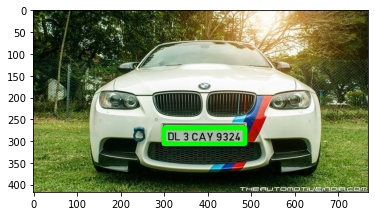

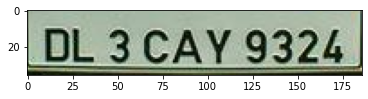

In [12]:
for i,y in enumerate(bboxes1):
#     bboxes1 = bboxes1.reshape(-1)
    xc, yc, w, h = y
    licennse_plate = img[int(yc - (h / 2)):int(yc + (h / 2)), int(xc - (w / 2)):int(xc + (w / 2)),:].copy()
    img = cv2.rectangle(img,(int(xc - (w / 2)), int(yc - (h / 2))),(int(xc + (w / 2)), int(yc + (h / 2))),(0, 255, 0),10)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(cv2.cvtColor(licennse_plate, cv2.COLOR_BGR2RGB))
    plt.show()

In [14]:
licennse_plate.shape

(36, 186, 3)

In [15]:
resized_licennse_plate = cv2.resize(licennse_plate,(720,360))

In [17]:
resized_licennse_plate.shape

(360, 720, 3)